In [1]:
print('Start import')
import socket 
import strax
import straxen
import numpy as np
import datetime
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import datetime
import pandas as pd
print(
f'''Working on {socket.getfqdn()} with the following versions 
and installation paths:
strax
\tv{strax.__version__}\t{str(strax.__path__[0])}
straxen
\tv{straxen.__version__}\t{str(straxen.__path__[0])}
''')
from multihist import Hist1d, Histdd
import time
import itertools
import os

from scipy import stats
from straxen import units
from scipy.optimize import curve_fit

import peaks_utility as psu
import drift_diffusion_utility as ddu

Start import
Working on midway2-0417.rcc.local with the following versions 
and installation paths:
strax
	v0.13.9	/dali/lgrandi/strax/strax/strax
straxen
	v0.15.5	/dali/lgrandi/strax/straxen/straxen



In [2]:
st = straxen.contexts.xenonnt_online()

In [3]:
dsets = st.select_runs(exclude_tags=('bad','messy'), run_mode='tpc_commissioning_kr*',
                       available=('event_info','peak_basics'))
#dsets = dsets[(dsets.end < pd.to_datetime('01/28/2021'))]
dsets = dsets[(dsets.end > pd.to_datetime('01/23/2021'))]
print('total number of runs:', len(dsets))

Checking data availability: 100%|██████████| 3/3 [17:02<00:00, 340.72s/it]

total number of runs: 172


In [4]:
dsets

,name,number,mode,end,start,tags,livetime,peak_basics_available,event_info_available,raw_records_available
905,012486,12486,tpc_commissioning_kr83m,2021-02-03 12:20:44.119,2021-02-03 11:20:44.023,,0 days 01:00:00.096000,True,True,False
907,012484,12484,tpc_commissioning_kr83m,2021-02-03 11:17:30.799,2021-02-03 10:33:56.327,,0 days 00:43:34.472000,True,True,False
909,012482,12482,tpc_commissioning_kr83m,2021-02-03 09:59:22.669,2021-02-03 09:41:08.543,,0 days 00:18:14.126000,True,True,False
910,012481,12481,tpc_commissioning_kr83m,2021-02-03 09:40:54.341,2021-02-03 08:40:53.778,,0 days 01:00:00.563000,True,True,False
915,012476,12476,tpc_commissioning_kr83m,2021-02-03 03:03:21.034,2021-02-03 02:03:20.485,,0 days 01:00:00.549000,True,True,False
...,...,...,...,...,...,...,...,...,...,...
1257,012134,12134,tpc_commissioning_kr83m,2021-01-26 19:41:32.315,2021-01-26 19:11:31.585,,0 days 00:30:00.730000,True,True,False
1259,012132,12132,tpc_commissioning_kr83m,2021-01-26 18:50:22.030,2021-01-26 18:35:19.659,,0 days 00:15:02.371000,True,True,False
1261,012130,12130,tpc_commissioning_kr83m,2021-01-26 18:17:30.264,2021-01-26 18:02:28.788,,0 days 00:15:01.476000,True,True,False
1263,012128,12128,tpc_commissioning_kr83m,2021-01-26 18:02:14.510,2021-01-26 17:47:14.434,,0 days 00:15:00.076000,True,True,False


# Kr-83m data

In [5]:
def plot_area_width_aft(events, run_id, low = 0, high = 6, low2 = 0, high2 = 1, binning = 500):
    ph_s1 = Histdd(events['s1_a_area'], events['s1_a_range_50p_area'],
                    bins=(np.logspace(low, high, binning), np.logspace(1, 6, binning)))
    ph_s2 = Histdd(events['s2_a_area'], events['s2_a_range_50p_area'],
                    bins=(np.logspace(low, high, binning), np.logspace(1, 6, binning)))
    phcs1 = Histdd(events['s1_a_area'], events['s1_a_area_fraction_top'],
                    bins=(np.logspace(low, high, binning), np.linspace(0, 1, binning)))
    phcs2 = Histdd(events['s2_a_area'], events['s2_a_area_fraction_top'],
                    bins=(np.logspace(low, high, binning), np.linspace(0, 1, binning)))
    plt.figure(figsize=(12,6))
    ph_s1.plot(log_scale=True, cblabel='S1 events',cmap='plasma')
    ph_s2.plot(log_scale=True, cblabel='S2 events')
    plt.xlabel("peak area (PE)", ha='right', x=1)
    plt.ylabel("peak width 50% (ns)", ha='right', y=1)
    plt.title(f'run {run_id}')
    plt.xscale('log')
    plt.yscale('log')
    plt.figure(figsize=(12,6))
    phcs1.plot(log_scale=True, cblabel='S1 events',cmap='plasma')
    phcs2.plot(log_scale=True, cblabel='S2 events')
    plt.xlabel("peak area (PE)", ha='right', x=1)
    plt.ylabel("area fraction top", ha='right', y=1)
    plt.title(f'run {run_id}')
    plt.xscale('log')

Loading event_info_double: |          | 0.00 % [00:00<?]

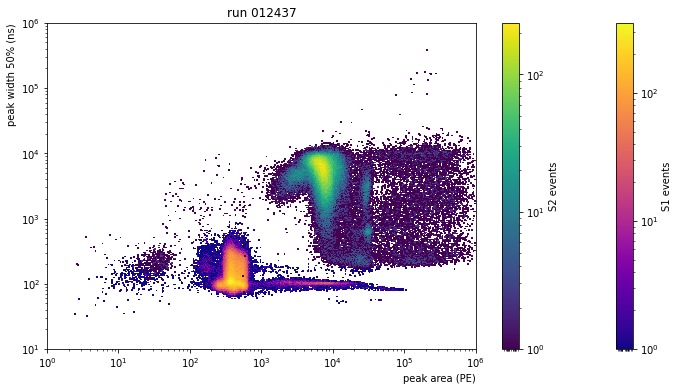

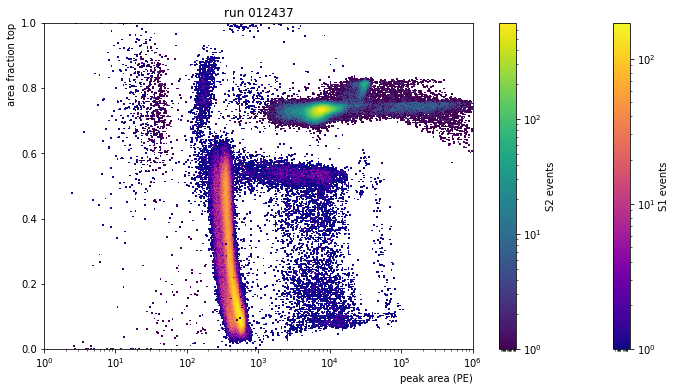

In [6]:
run_kr = '012437'  #2021-01-28 14:00 new data with a liquid level of ~5.5 mm
events = st.get_df(run_kr,'event_info_double')
plot_area_width_aft(events,run_kr)

# Cut KrSingleS1 (from Maxime)

In [7]:
def mask_KrSingleS1(df):
    def line(x):
        return 0.55 * x + 15
    mask = (df['ds_s1_dt'] == 0)
    mask &= (df['s1_a_n_channels'] >= 90) & (df['s1_a_n_channels'] < 225)
    mask &= (line(df['s1_a_area']) > df['s1_a_n_channels'])
    mask &= (df['s1_a_range_50p_area'] >= 60) & (df['s1_a_range_50p_area'] < 1000)
    mask &= (df['s1_a_area_fraction_top'] < 0.68)
    return mask

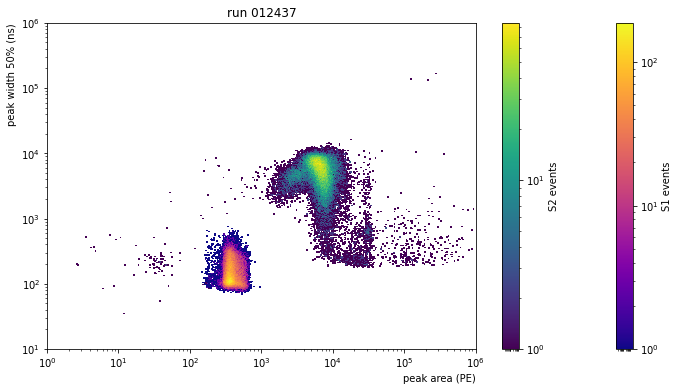

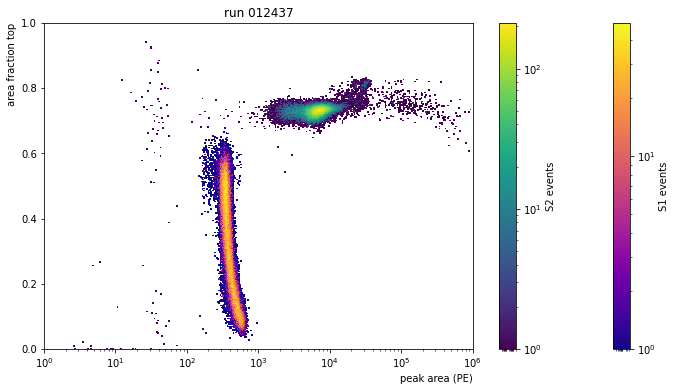

In [8]:
mask_singleS1 = mask_KrSingleS1(events)
plot_area_width_aft(events[mask_singleS1], run_kr)

# Cut KrDouble (from Maxime)

In [9]:
def mask_KrDouble(df,doubleS2=False):
    def line(x,a,b):
        return a*x+b
 
    w_SE= 599.70428e-3
    w_t0= 400.29572e-3
    t_0= 1.0029191e-3
    def diffusion_model(t,w_SE, w_t0, t_0):
        return np.sqrt(w_SE**2 + ((w_t0 - w_SE)**2 /t_0) * t)
 
    mask = (df['s1_a_n_channels'] >= 80) & (df['s1_a_n_channels'] < 225)
    mask &= (df['s1_b_n_channels'] >= 25) & (df['s1_b_n_channels'] < 125)
    mask &= (df['s1_b_distinct_channels'] >= 0) & (df['s1_b_distinct_channels'] < 60)
    mask &= (df['ds_s1_dt'] >= 750) & (df['ds_s1_dt'] < 2000)
    mask &= df['s1_a_area_fraction_top'] < line(df['drift_time'],-2.3e-7,0.70)
    mask &= df['s1_a_area_fraction_top'] > line(df['drift_time'],-2e-7,0.40)
    #mask &= df['s2_a_range_50p_area']/diffusion_model(df['drift_time'], w_SE, w_t0, t_0) > -30/(df['drift_time']*1e-3+10)+0.8
    #mask &= df['s2_a_range_50p_area']/diffusion_model(df['drift_time'], w_SE, w_t0, t_0) < 30/(df['drift_time']*1e-3+10)+1.2
    mask &= df['drift_time']*1e-3 < 2400
    if (doubleS2): mask &= (df['ds_s2_dt'] > 600)&(df['ds_s2_dt'] < 2000)
    return mask

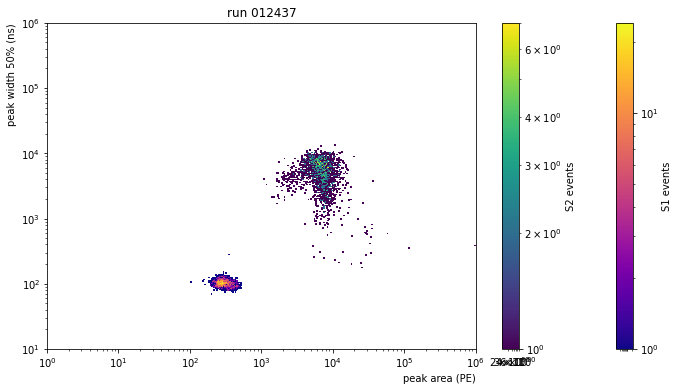

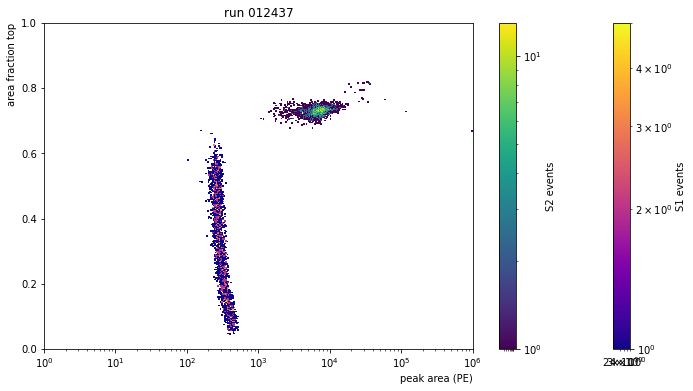

In [10]:
mask_doubleS1 = mask_KrDouble(events)
plot_area_width_aft(events[mask_doubleS1], run_kr)

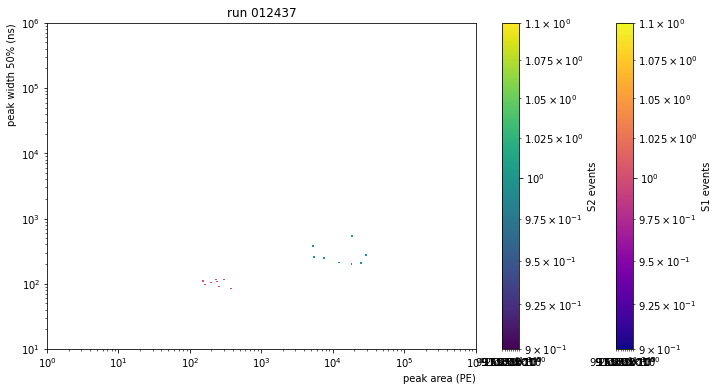

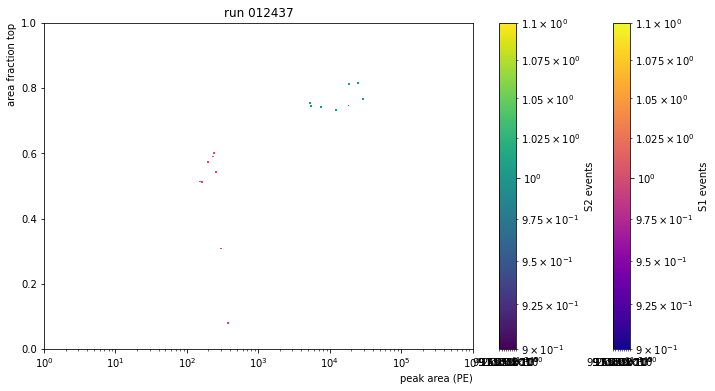

In [11]:
mask_doubleS1S2 = mask_KrDouble(events,True)
plot_area_width_aft(events[mask_doubleS1S2], run_kr)

# Cut on S2 Area, Width and Area Fraction Top

In [12]:
def mask_s2_area_width_aft(events, run_id, area_cut, width_cut,aft_cut, plot = False,
                          low = 1, high = 6, low2 = 2, high2 = 4.5, low3 = 0.4, high3 = 0.9, binning=500):
    ph_s2 = Histdd(events['s2_a_area'], events['s2_a_range_50p_area'],
                    bins=(np.logspace(low, high, binning), np.logspace(low2, high2, binning)))
    phcs2 = Histdd(events['s2_a_area'], events['s2_a_area_fraction_top'],
                    bins=(np.logspace(low, high, binning), np.linspace(low3, high3, binning)))
    if plot:
        plt.figure(figsize=(12,6))
        ph_s2.plot(log_scale=True, cblabel='S2 events')
        plt.xlabel("peak area (PE)", ha='right', x=1)
        plt.ylabel("peak width 50% (ns)", ha='right', y=1)
        plt.title(f'run {run_id}')
        plt.xscale('log')
        plt.yscale('log')
        psu.rectangle(area_cut, width_cut, 'r')
        
        plt.figure(figsize=(12,6))
        phcs2.plot(log_scale=True, cblabel='S2 events')
        plt.xlabel("peak area (PE)", ha='right', x=1)
        plt.ylabel("area fraction top", ha='right', y=1)
        plt.title(f'run {run_id}')
        plt.xscale('log')
        psu.rectangle(area_cut, aft_cut, 'r')
    mask = (events['s2_a_area'] > area_cut[0]) & (events['s2_a_area'] < area_cut[1])
    mask &= (events['s2_a_range_50p_area'] > width_cut[0]) & (events['s2_a_range_50p_area'] < width_cut[1])
    mask &= (events['s2_a_area_fraction_top'] > aft_cut[0]) & (events['s2_a_area_fraction_top'] < aft_cut[1])
    return mask

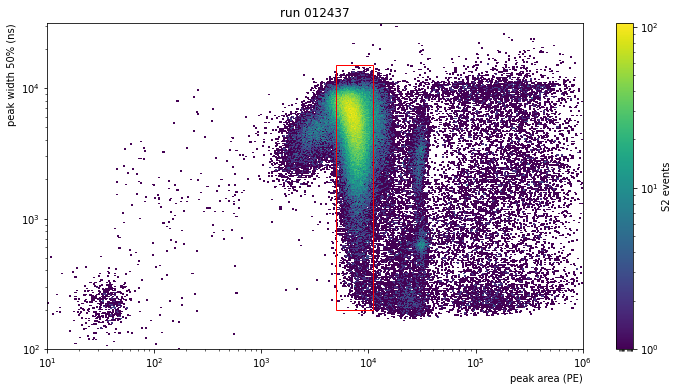

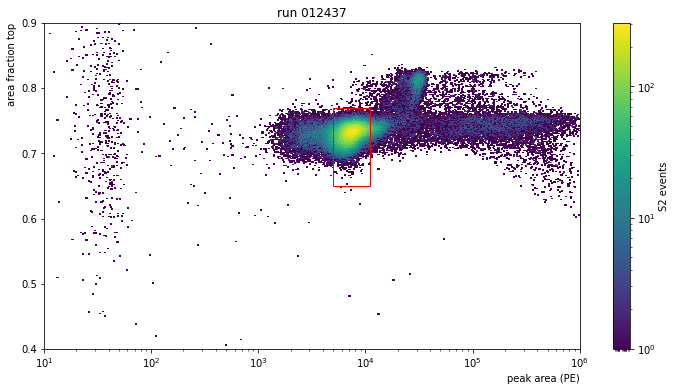

In [13]:
mask_awt = mask_s2_area_width_aft(events,run_kr,area_cut=(5e3,1.1e4),width_cut=(200,1.5e4),aft_cut=(0.65,0.77),plot=True)

In [14]:
def s2_width_vs_dt(dt,s2width, run_id):
    t = np.linspace(0, 3000, 200)
    ph = Histdd(dt, s2width,bins=(t, np.linspace(100, 15e3, 200)))
    plt.figure(figsize=(12,6))
    ph.plot(log_scale=True, cblabel='events')
    plt.xlabel("drift time (us)", ha='right', x=1,fontsize=12)
    plt.ylabel("S2 width 50% (ns)", ha='right', y=1,fontsize=12)
    plt.title(f'run {run_id}',fontsize=14)

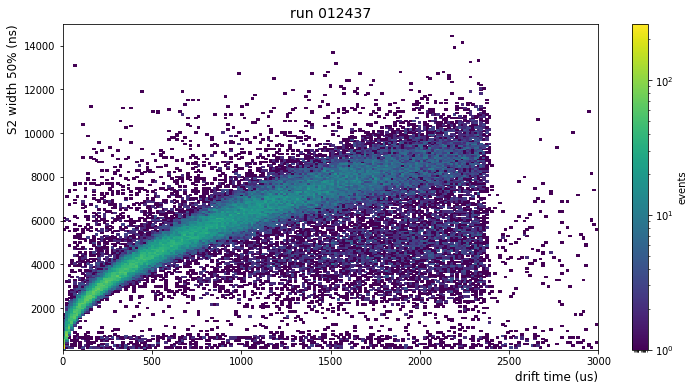

In [15]:
e1 = events[mask_singleS1]
s2_width_vs_dt(e1['drift_time']/1e3,e1['s2_a_range_50p_area'],run_kr)

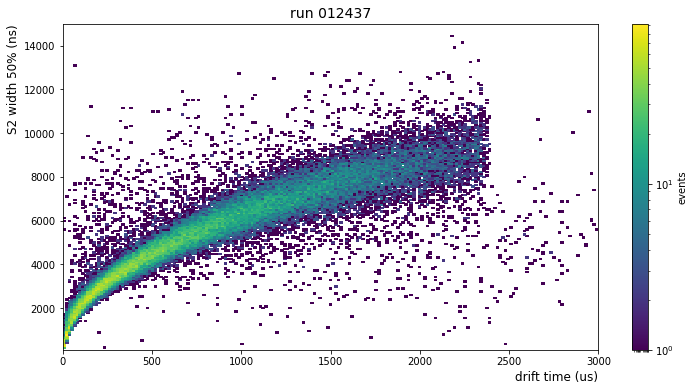

In [16]:
e2 = events[mask_singleS1 & mask_awt]
s2_width_vs_dt(e2['drift_time']/1e3,e2['s2_a_range_50p_area'],run_kr)

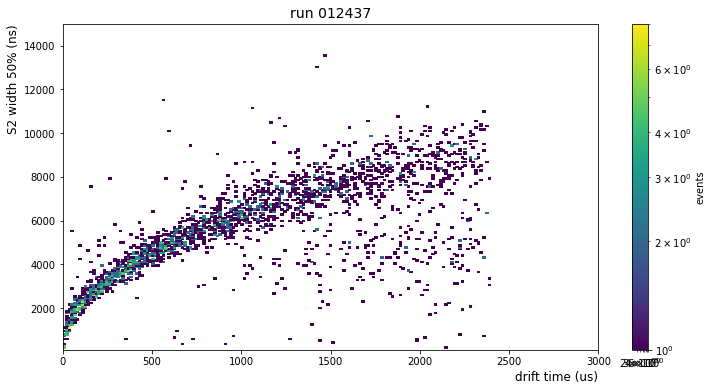

In [17]:
e3 = events[mask_doubleS1]
s2_width_vs_dt(e3['drift_time']/1e3,e3['s2_a_range_50p_area'],run_kr)

# Drift Velocity

In [18]:
def drift_velocity(events, run_id, low = 0, high = 3000, binning = 200,cat_lim=50,gate_pos=5.5,perc=1,plot=False):
    
    if 'area_ratio' in events: pass
    else: events.insert(1, 'area_ratio', np.divide(events['cs2_a'],events['cs1_a']))
    events = events[events['area_ratio']<1e3]
    
    dt = np.linspace(low, high, binning)
    hdtime = Hist1d(events['drift_time']/1e3, bins=dt)
    dropoff = dt[np.where(np.array(hdtime)>cat_lim)[0][-1]]
    if plot:
        plt.figure(figsize=(12,6))
        hdtime.plot(color='b',label='data')
        plt.ylabel("events", ha='right', y=1)
        plt.xlabel("drift time ($\mu$s)", ha='right', x=1)
        plt.yscale('log')
        plt.axvline(x=dropoff,linewidth=1,linestyle='--', color='r',label=f'cathode drop-off = {dropoff:.1f} us')
        plt.legend(fontsize=14)
    
    mh = Histdd(events['drift_time']/1e3, events['area_ratio'],
            bins=(np.linspace(low, high, binning), np.logspace(0, 5, 200)))
    if plot:
        plt.figure(figsize=(12,6))
        mh.plot(log_scale=True, cblabel='events')
        plt.xlabel("drift time ($\mu$s)", ha='right', x=1,fontsize=12)
        plt.ylabel("cS2/cS1", ha='right', y=1,fontsize=12)
        plt.title(f'run {run_id}',fontsize=14)
        plt.yscale('log')
        plt.xlim(1.5e3,high)
        plt.axvline(x=dropoff,linewidth=1,linestyle='-', color='r',label=f'cathode drop-off = {dropoff:.1f} us')
        plt.axvline(x=dropoff+dropoff*perc/100,linewidth=1,linestyle='--', color='r')
        plt.axvline(x=dropoff-dropoff*perc/100,linewidth=1,linestyle='--', color='r')
    
    
    dts = np.linspace(0, 20, 200)
    mh_low = Histdd(events['drift_time']/1e3, events['area_ratio'],
            bins=(dts, np.logspace(0, 5, 200)),axis_names=['drift_time', 'area_ratio'])
    median = mh_low.percentile(50, axis='area_ratio')
    gatedt = gate_pos#dts[np.where(np.array(median[:int(len(median)/2)])>50)[0][-1]]
    vd = 1485/(dropoff-gatedt)
    
    if plot:
        plt.figure(figsize=(12,6))
        mh_low.plot(log_scale=True, cblabel='events')
        plt.xlabel("drift time ($\mu$s)", ha='right', x=1,fontsize=12)
        plt.ylabel("cS2/cS1", ha='right', y=1,fontsize=12)
        plt.title(f'run {run_id}',fontsize=14)
        median.plot(color='red',label='median')
        plt.yscale('log')
        plt.axvline(x=gatedt,linewidth=1,linestyle='--', color='b',label=f'gate drift time = {gatedt:.1f} $\mu$s')
        plt.legend(fontsize=14)
        print(f'Drift velocity = {vd:.3f} mm/$\mu$s')
    return vd

Drift velocity = 0.629 mm/$\mu$s


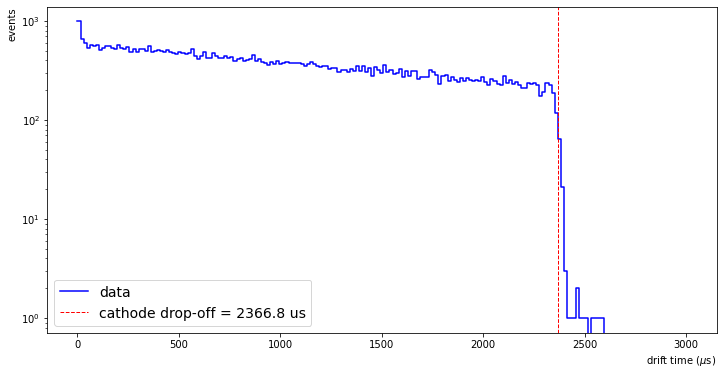

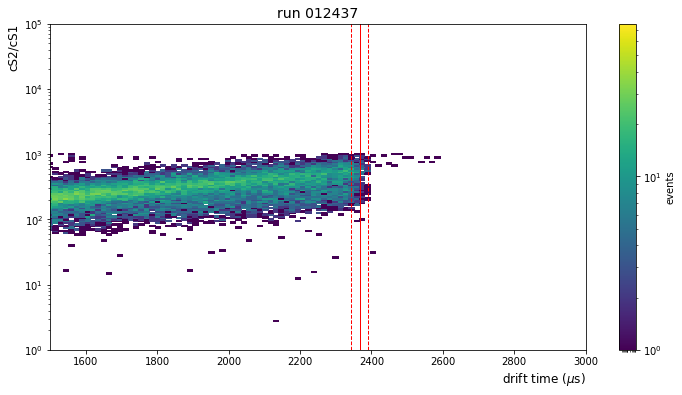

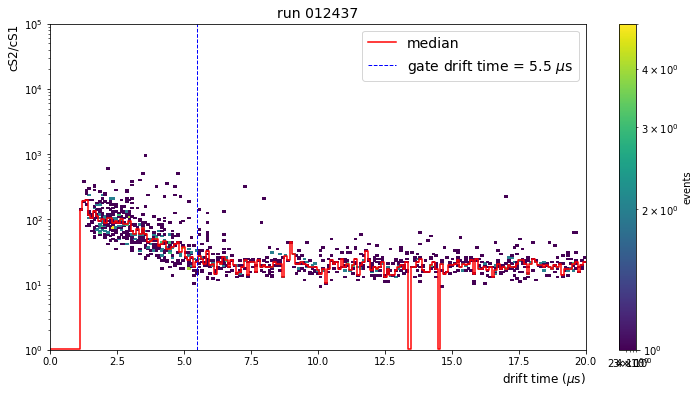

In [19]:
vd_kr = drift_velocity(e1, run_kr, plot = True )

In [20]:
def diffusion_constant(events, run_id, fit_range, vd = 600, plot = False):
    # s2_width_50 vs drift_time
    t = np.linspace(0, 2400, 200)
    ph = Histdd(events['drift_time']/1e3, events['s2_a_range_50p_area'],
                bins=(t, np.linspace(100, 15e3, 200)))
    perc50 = np.array(ph.percentile(percentile=50, axis=1))
    
    D_guess = 45e3 * units.cm**2 / units.s
    w0_guess = 500 * units.ns
    vd = vd * units.mm / units.us
    guess = np.array([D_guess, vd, w0_guess])
    ys_m = ddu.diffusion_model(t, *guess)
    ll = np.where(t>fit_range[0])[0][0]
    hh = np.where(t>fit_range[1])[0][0]
    diffusion = lambda x, D, w0: ddu.diffusion_model(x, D, vd, w0)
    popt, pcov = curve_fit(diffusion, t[ll:hh], perc50[ll:hh], p0=(D_guess, w0_guess))
    perr = np.sqrt(np.diag(pcov))
    
    ys_u = diffusion(t, *popt) + 1000
    ys_m = diffusion(t, *popt)
    ys_d = diffusion(t, *popt) - 1000
    diff_const = popt[0]/1e3/(units.cm**2 / units.s)
    diff_const_err = perr[0]/1e3/(units.cm**2 / units.s)
    
    if plot:
        plt.figure(figsize=(12,6))
        ph.plot(log_scale=True, cblabel='events')
        plt.xlabel("drift time (us)", ha='right', x=1,fontsize=12)
        plt.ylabel("S2 width 50% (ns)", ha='right', y=1,fontsize=12)
        plt.title(f'run {run_id}',fontsize=14)
        plt.plot(t[:len(perc50)], perc50, color='b',linestyle='--', label='50% percentile')
        plt.axvspan(*fit_range, alpha=0.1, color='blue', label='fit region')
        plt.plot(t, ys_m, label=f'$D = {popt[0]/1e3/(units.cm**2 / units.s):.2f}$ cm$^2$/s',color='r')
        plt.legend(fontsize=14)
        print(f'Diffusion constant = {diff_const:.2f} +/- {diff_const_err:.2f} cm$^2$/s ')
    return diff_const, diff_const_err

Diffusion constant = 42.52 +/- 0.13 cm$^2$/s 


(42.52473617751962, 0.12987350707511267)

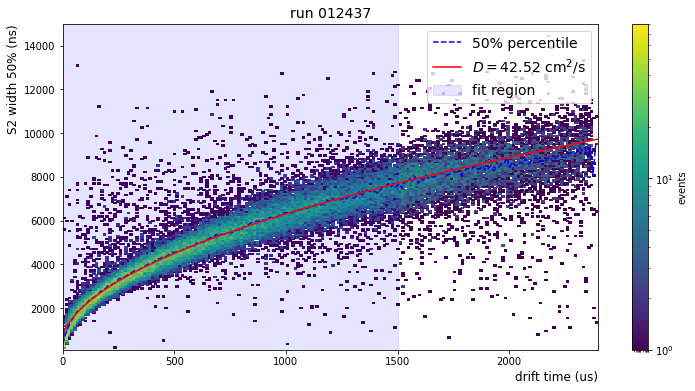

In [21]:
diffusion_constant(e2,run_kr,fit_range=(1,1500),vd = vd_kr,plot=True)

In [22]:
def diffusion_analysis(run_kr, area_cut=(5e3,1.1e4), fit_range=(1,1500), cat_lim = 50, gate_pos = 5.5, plot=False):
    run = int(run_kr)
    events = st.get_df(run_kr,'event_info_double',progress_bar=False)
    if(plot): plot_area_width_aft(events, run_kr)
    mask_singleS1 = mask_KrSingleS1(events)
    if(plot): plot_area_width_aft(events[mask_singleS1], run_kr)
    e1 = events[mask_singleS1]
    mask_awt = mask_s2_area_width_aft(events,run_kr,area_cut,width_cut=(200,1.5e4),aft_cut=(0.65,0.77),plot=plot)
    e2 = events[mask_singleS1 & mask_awt]
    vd = drift_velocity(e1, run_kr, cat_lim = cat_lim, gate_pos = gate_pos,plot=plot)
    d, d_err = diffusion_constant(e2,run_kr,fit_range=(1,1500),vd = vd,plot=plot)
    return run, vd, d, d_err

In [23]:
d_ll5 = dsets[(dsets.number<=12245) & (dsets.livetime>np.timedelta64(30,'m'))] # 2021-01-26 19:11:31 - 2021-01-28 14:16:19
run_ll5 = np.array(d_ll5['name'])

In [24]:
d_ll5

,name,number,mode,end,start,tags,livetime,peak_basics_available,event_info_available,raw_records_available
1146,012245,12245,tpc_commissioning_kr83m,2021-01-28 14:16:19.514,2021-01-28 13:46:19.358,,0 days 00:30:00.156000,True,True,False
1160,012231,12231,tpc_commissioning_kr83m,2021-01-28 08:06:46.342,2021-01-28 07:36:46.081,,0 days 00:30:00.261000,True,True,False
1162,012229,12229,tpc_commissioning_kr83m,2021-01-28 07:06:17.583,2021-01-28 06:36:15.942,,0 days 00:30:01.641000,True,True,False
1165,012226,12226,tpc_commissioning_kr83m,2021-01-28 05:35:21.837,2021-01-28 05:05:21.605,,0 days 00:30:00.232000,True,True,False
1168,012223,12223,tpc_commissioning_kr83m,2021-01-28 04:04:35.194,2021-01-28 03:34:34.970,,0 days 00:30:00.224000,True,True,False
1169,012222,12222,tpc_commissioning_kr83m,2021-01-28 03:34:20.845,2021-01-28 03:04:20.655,,0 days 00:30:00.190000,True,True,False
1170,012221,12221,tpc_commissioning_kr83m,2021-01-28 03:04:06.479,2021-01-28 02:34:06.188,,0 days 00:30:00.291000,True,True,False
1172,012219,12219,tpc_commissioning_kr83m,2021-01-28 02:03:34.390,2021-01-28 01:33:34.155,,0 days 00:30:00.235000,True,True,False
1173,012218,12218,tpc_commissioning_kr83m,2021-01-28 01:33:16.910,2021-01-28 01:03:16.741,,0 days 00:30:00.169000,True,True,False
1174,012217,12217,tpc_commissioning_kr83m,2021-01-28 01:03:02.556,2021-01-28 00:33:02.022,,0 days 00:30:00.534000,True,True,False


In [25]:
runs, vd, d, d_err = np.zeros(len(d_ll5)), np.zeros(len(d_ll5)), np.zeros(len(d_ll5)), np.zeros(len(d_ll5))
for i, run in enumerate(run_ll5):
    runs[i], vd[i], d[i], d_err[i] = diffusion_analysis(run, area_cut=(4e3,1.1e4), cat_lim = 10, gate_pos = 5.5)

<ErrorbarContainer object of 3 artists>

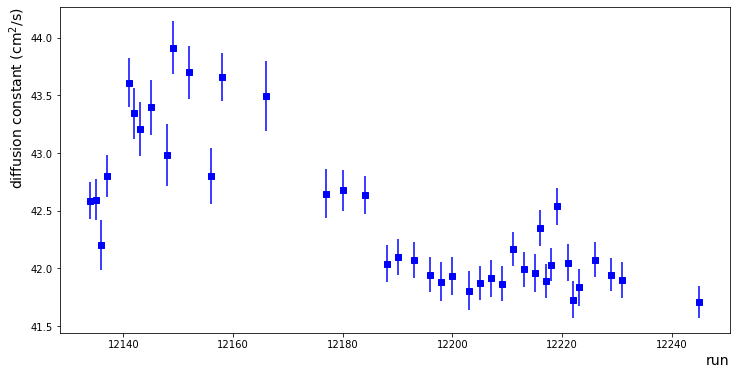

In [26]:
plt.figure(figsize=(12,6))
plt.xlabel("run", ha='right', x=1,fontsize=14)
plt.ylabel("diffusion constant (cm$^2$/s)", ha='right', y=1,fontsize=14)
plt.errorbar(runs,d,yerr=d_err,fmt='s',color='b')

<ErrorbarContainer object of 3 artists>

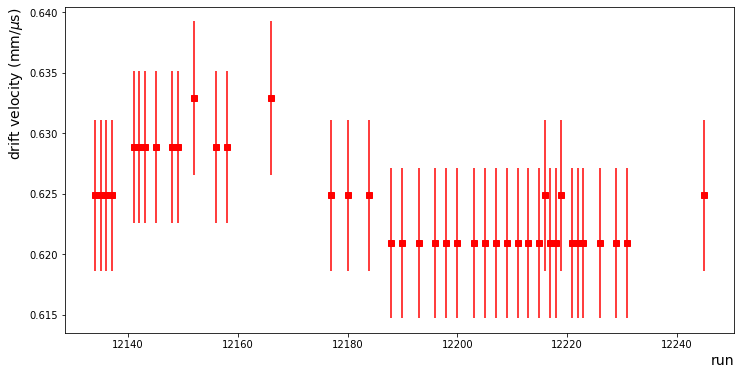

In [29]:
plt.figure(figsize=(12,6))
plt.xlabel("run", ha='right', x=1,fontsize=14)
plt.ylabel("drift velocity (mm/$\mu$s)", ha='right', y=1,fontsize=14)
plt.errorbar(runs,vd,yerr=vd*0.01,fmt='s',color='r')

Drift velocity = 0.625 mm/$\mu$s
Diffusion constant = 42.59 +/- 0.16 cm$^2$/s 


(12134, 0.6248922882055716, 42.58731614771862, 0.1626483885039835)

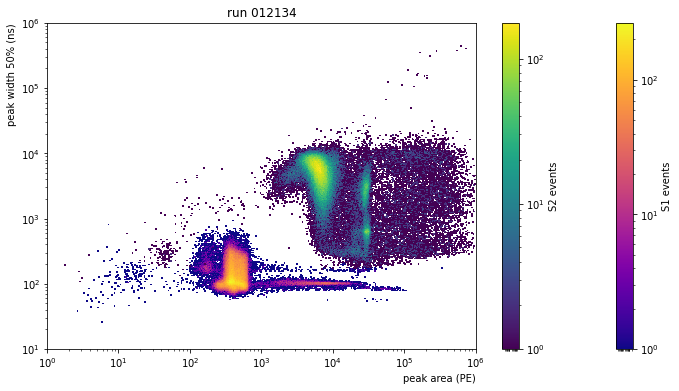

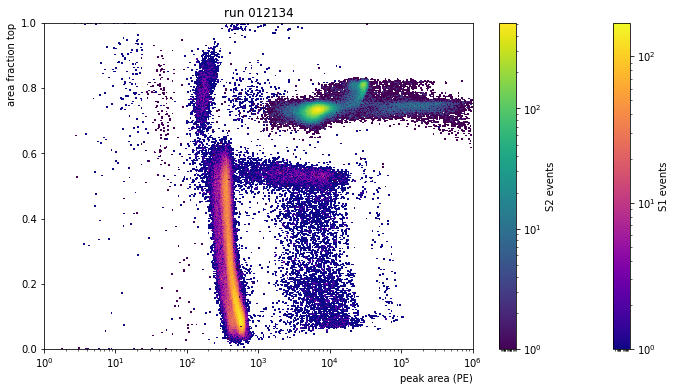

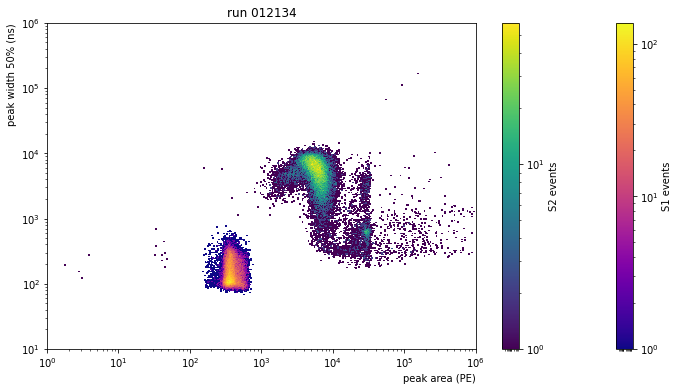

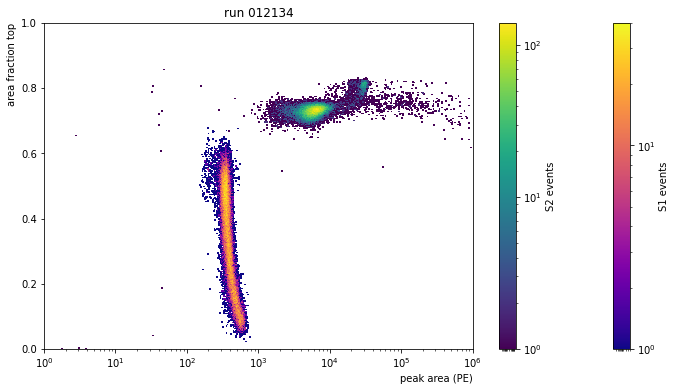

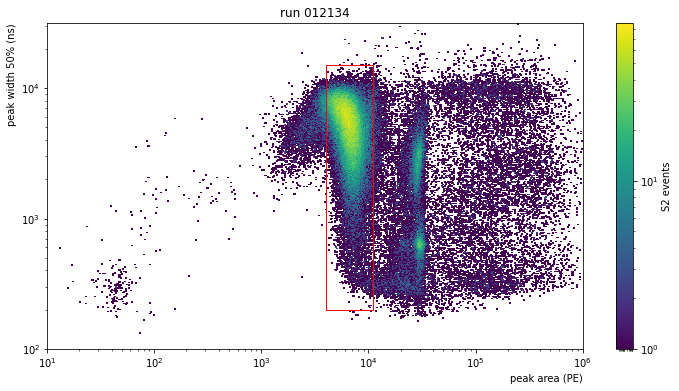

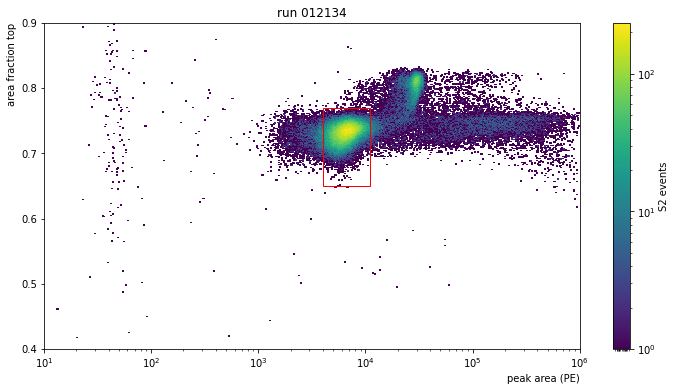

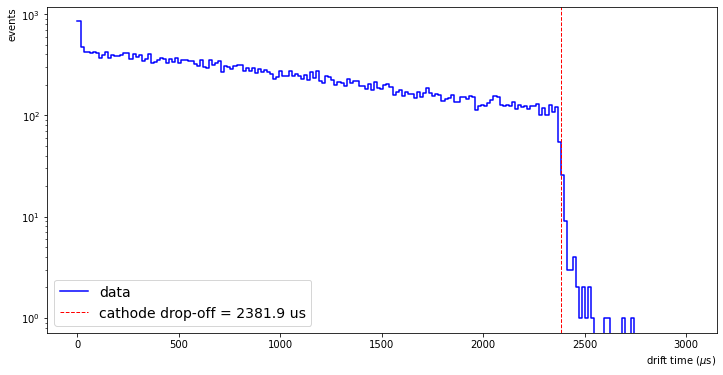

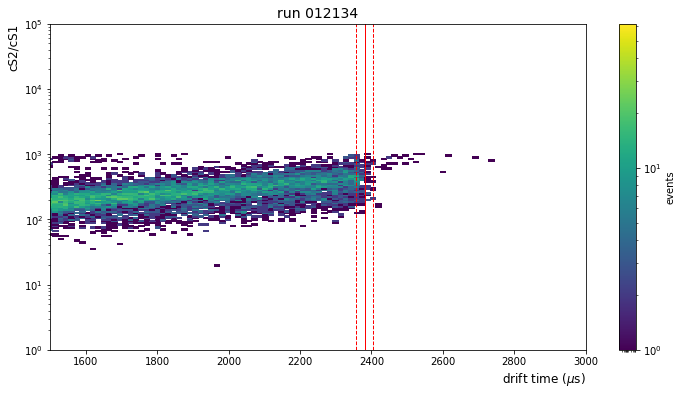

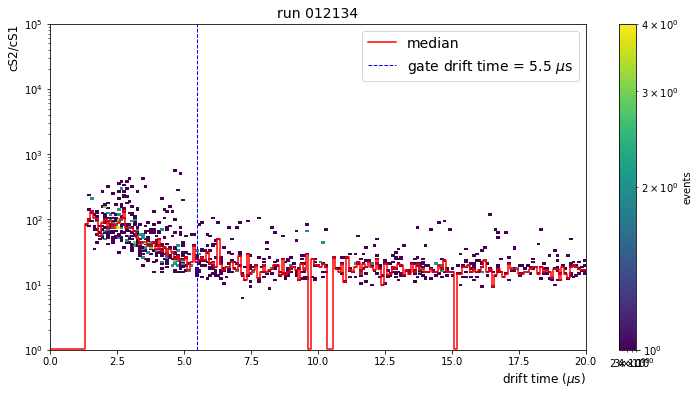

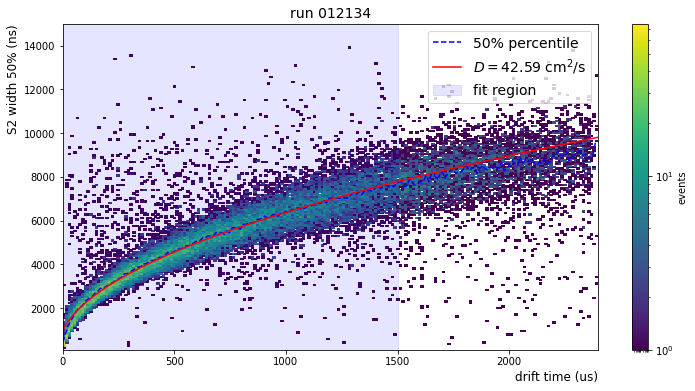

In [254]:
diffusion_analysis('012134', area_cut=(4e3,1.1e4), cat_lim = 10, gate_pos = 5.5,plot=True)

# Cut S2 Width vs Drift Time

In [64]:
def s2width(dt, kind):
    "dt in us"
    if kind == "upper":
        # width = (800 ** 2 + (6000 ** 2 - 800 ** 2) / 800 * dt) ** 0.5 + 1100
        # width = (1000 ** 2 + (10500 ** 2 - 1000 ** 2) / 2400 * dt) ** 0.5 + 1100
        # from valerio's study
        width = _s2width(dt) + 1000
    elif kind == "lower":
        width = (800 ** 2 + (9200 ** 2 - 800 ** 2) / 2400 * dt) ** 0.5 - 1100
        # width = _s2width(dt) - 2000
    return width

def _s2width(t):
    """from valerio's study, https://xe1t-wiki.lngs.infn.it/doku.php?id=dandrea:krdata-s2event"""
    # assumed omega 0
    omega_0 = 1000  # us
    D = 51.89  # cm^2/s
    v = 0.63  # mm/us
    # output is ns
    coeff = 1e2
    width = np.sqrt(omega_0 ** 2 + 3.6395*D*t/v**2*coeff)
    return width

def AddS2WidthCut(df):
    mask_s2width = (df.s2_range_50p_area > s2width(df.drift_time/1e3, "lower")) \
                   & (df.s2_range_50p_area < s2width(df.drift_time/1e3, "upper"))
    # non-zero drif time
    mask_s2width &= df.drift_time > 0
    #df["CutS2Width"] = mask_s2width
    return mask_s2width

Loading event_info: |          | 0.00 % [00:00<?]

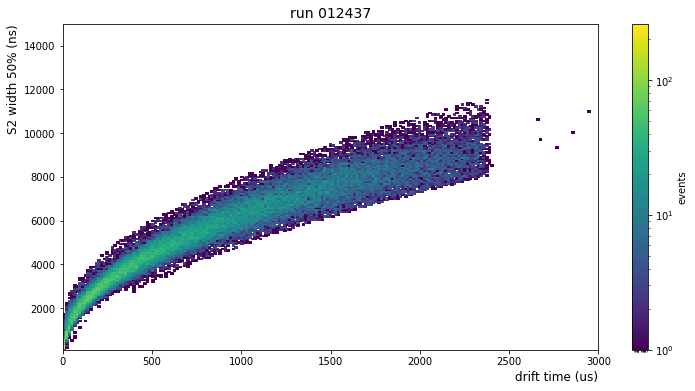

In [69]:
ev = st.get_df(run_kr,'event_info')
mask_s2width = AddS2WidthCut(ev)
ev2 = ev[mask_KrS1 & mask_s2width]
s2_width_vs_dt(ev2['drift_time']/1e3,ev2['s2_range_50p_area'],run_kr)

# Cut S1 Area Fraction Top vs Drift Time

In [135]:
def s1aft_dt_upper(dt):
    return dt*(0.65-0)/(0-3000) + 0.65

def s1aft_dt_lower(dt):
    return dt*(0.45-0.0)/(0-2000) + 0.45

def AddS1AFTCut(df):
    mask = (df.s1_area_fraction_top > s1aft_dt_lower(df.drift_time/1e3)) \
           & (df.s1_area_fraction_top < s1aft_dt_upper(df.drift_time/1e3))
    df["CutS1AFT"] = mask
    return df